# Import library

In [1]:
from En_system_intergrated import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import constant as c

# dm.util.use_dmpl_style()
# plt.rcParams['font.family'] = 'Roboto'

Load colors...
Load colormaps...


# Electric boiler

In [ ]:
Elec_boiler = ElectricBoiler()
Elec_boiler.T_w_tank = c.C2K(70)
Elec_boiler.system_update()

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(8), dm.cm2in(4.5)), dpi=200, facecolor=None, edgecolor='k')

for idx in range(ncols):
    data = list(Elec_boiler.exergy_balance.values())[idx]
    keys = list(Elec_boiler.exergy_balance.keys())[idx]
    values = list(data.values())
    labels = list(data.keys())

    group_margin = 0.3  # margin between groups
    bar_margin = 0.1  # margin between bars
    bar_width = 0.2

    dN = len(data)  # number of data
    x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)])
    gl1 = [[2, 1, 2], [2, 1, 1], [2, 1, 2], [2, 1, 2]][idx]  # group
    gN = len(gl1)  # number of groups
    gl2 = np.cumsum(gl1)

    x_pos = x_pos0[:gl2[0]].tolist()
    for i in range(gN - 1):  # Add group_margin between arrays
        x_pos.extend((x_pos0[gl2[i]:gl2[i + 1]] + group_margin * (i + 1)).tolist())

    # Plot parameters
    sp_ratio = 0.5
    xmar = bar_width
    xmax = max(x_pos)
    xmin = min(x_pos)
    ymar = 0
    ymax = 3000
    ymin = 0
    yint = 200

    # Create vertical bars
    bars = ax[idx].bar(x_pos, values, bar_width, color=['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5'])

    # Annotation
    ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',fontweight=500,
                      horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(1.5))

    # Add value labels on top of each bar
    for bidx, bar in enumerate(bars):
        height = bar.get_height()
        ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                     f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-3), fontweight=400)

    # Axes limits
    ax[idx].set_xlim(xmin - xmar, xmax + xmar)
    ax[idx].set_ylim(ymin - ymar, ymax + ymar)

    # Labels and ticks
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(labels, rotation=90, ha='center', fontsize=dm.fs(-1))
    ax[idx].set_yticks([])  # No y-ticks

    # Tick parameters
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1),
                        which='major', length=0, width=0.5 * sp_ratio, pad=300)
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=0, width=0.25 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='major', length=2, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                        which='minor', length=1, width=0.25 * sp_ratio, pad=3)

    # Minor ticks
    ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

    # Spines
    for k in ['top', 'left', 'right']:  # Only keep bottom spine
        ax[idx].spines[k].set_visible(False)
    ax[idx].spines['bottom'].set_linewidth(0.5 * sp_ratio)
    ax[idx].spines['bottom'].set_color('k')

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, bbox=(0, 1, 0.2, .95), verbose=False)
img_stem = f'../figure/ElectricBoiler_exergy_results(T_w_tank={c.K2C(Elec_boiler.T_w_tank):.0f})'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


# Gas boiler

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

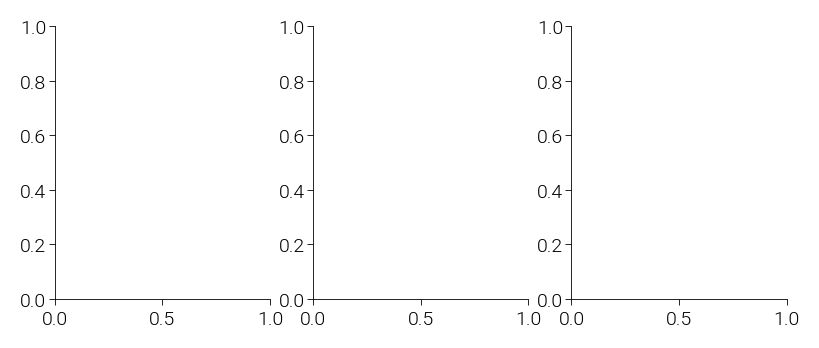

In [8]:
GB = GasBoiler()
GB.T_w_tank = c.C2K(60)
GB.x_ins = 0.05
GB.system_update()

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 3  # 가로 방향으로 3개의 subplot
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(12), dm.cm2in(4.5)), dpi=200, facecolor=None, edgecolor='k')

for idx in range(ncols):
    data = [entry['value'] for k,v in GB.exergy_balance.items() for sublist in list(v.values()) for entry in sublist]
    labels = [k for k,v in GB.exergy_balance.items()] 
    
    group_margin = 0.15  # margin between groups
    bar_margin = 0  # margin between bars
    bar_width = 0.2

    dN = len(data)  # number of data
    x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)])
    gl1 = [[2,1,2],[1,1,2],[2,1,2],[2,1,2]][idx]  # group
    gN = len(gl1)  # number of groups
    gl2 = np.cumsum(gl1)

    x_pos = x_pos0[:gl2[0]].tolist()
    for i in range(gN - 1):  # Add group_margin between arrays
        x_pos.extend((x_pos0[gl2[i]:gl2[i + 1]] + group_margin * (i + 1)).tolist())

    # Plot parameters
    sp_ratio = 0.5
    xmar = bar_width
    xmax = max(x_pos)
    xmin = min(x_pos)
    ymar = 0
    ymax = 3000
    ymin = 0
    yint = 200

    # Create vertical bars with different colors for each subplot
    bars = ax[idx].bar(x_pos, values, bar_width, 
                      color=[['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5'],
                            ['dm.red6', 'dm.yellow6', 'dm.green6', 'dm.lime5'],
                            ['dm.red6', 'dm.red5', 'dm.yellow6', 'dm.green6', 'dm.lime5']][idx])

    # Annotation
    ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), 
                     xycoords='axes fraction', weight='bold', color='dm.gray9',
                     horizontalalignment='center', verticalalignment='bottom', 
                     fontsize=dm.fs(1.5))

    # Add value labels on top of each bar
    for bidx, bar in enumerate(bars):
        height = bar.get_height()
        ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2), fontweight=400)

    # Axes limits
    ax[idx].set_xlim(xmin - xmar, xmax + xmar)
    ax[idx].set_ylim(ymin - ymar, ymax + ymar)

    # Labels and ticks
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(labels, rotation=90, ha='center', fontsize=dm.fs(-1))
    ax[idx].set_yticks([])  # No y-ticks

    # Tick parameters
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1),
                       which='major', length=0, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-2),
                       which='minor', length=0, width=0.25 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                       which='major', length=2, width=0.5 * sp_ratio, pad=3)
    ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-2),
                       which='minor', length=1, width=0.25 * sp_ratio, pad=3)

    # Minor ticks
    ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

    # Spines
    for k in ['top', 'left', 'right']:  # Only keep bottom spine
        ax[idx].spines[k].set_visible(False)
    ax[idx].spines['bottom'].set_linewidth(0.5 * sp_ratio)
    ax[idx].spines['bottom'].set_color('k')

plt.subplots_adjust(hspace=0.6)
dm.simple_layout(fig, bbox=(0, 1, 0.1, .97), verbose=False)
img_stem = f'../figure/Gas_boiler_exergy_results(T_w_tank={c.K2C(GB.T_w_tank):.0f})'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)

# Energy use, Primary energy use, CO2 emission, Exergy efficiency

In [2]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

# Primary energy factor
PEF_elec = 2.75 
PEF_NG = 1.1

# CO2 emission factor
Wh2MJ = 10**6/(1*c.h2s) # c.h2s = 3600 s/h
C_to_CO2 = 44/12 # 탄소 배출량당 이산화탄소 배출량 분자량에 의한 환산계수 
CF_NG_ori = 15.281 # tC/TJ = kgC/GJ = gC/MJ

CF_elec = 0.4747 # tCO2/MWh = gCO2/Wh
CF_NG = (CF_NG_ori*C_to_CO2)/Wh2MJ # gCO2/Wh

# Energy use
energy_use = [
        EB.energy_balance['hot water tank']['in'][0]['value'],
        GB.energy_balance['combustion chamber']['in'][0]['value'],
        HPB.energy_balance['refrigerant loop']['in'][0]['value'] + HPB.energy_balance['external unit']['in'][0]['value']
]

# Exergy use
exergy_use = [
        EB.exergy_balance['hot water tank']['in'][0]['value'],
        GB.exergy_balance['combustion chamber']['in'][0]['value'],
        HPB.exergy_balance['refrigerant loop']['in'][0]['value'] + HPB.exergy_balance['external unit']['in'][0]['value']
]

# Primary energy use
primary_energy_use = [
        energy_use[0] * PEF_elec,
        energy_use[1] * PEF_NG,
        energy_use[2] * PEF_elec,
]

# CO2 emission
CO2_emission = [
        energy_use[0] * CF_elec, 
        energy_use[1] * CF_NG,
        energy_use[2] * CF_elec
]

eX_consum = [
        calculate_total_exergy_consumption(EB.exergy_balance),
        calculate_total_exergy_consumption(GB.exergy_balance),
        calculate_total_exergy_consumption(HPB.exergy_balance),
]

eX_efficiency = [
        EB.exergy_balance['mixing valve']['out'][0]['value']/exergy_use[0]*100,
        GB.exergy_balance['mixing valve']['out'][0]['value']/exergy_use[1]*100,
        HPB.exergy_balance['mixing valve']['out'][0]['value']/exergy_use[2]*100
]

# Create figure and axis - adjust figure size for vertical layout
nrows = 1
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(dm.cm2in(16), dm.cm2in(3.5)), dpi=200, facecolor=None, edgecolor='k')

for ridx in range(nrows):
    for cidx in range(ncols):
        idx    = ridx * ncols + cidx
        data   = [energy_use, primary_energy_use, CO2_emission, eX_efficiency][idx]
        keys   = ['Energy use [W]', 'Primary energy use [W]', 'CO$_2$ emission [gCO$_2$/h]', 'Exergy efficiency [%]'][idx]
        labels = [['EB', 'GB', 'HPB'], # ['EB\n$(E_{heater}$)', 'GB\n$(E_{NG})$', 'HPB\n$(E_{fan} + E_{cmp})$']
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB'],
                  ['EB', 'GB', 'HPB']][idx]

        group_margin = 0.15  # margin between groups
        bar_margin   = 0.1  # margin between bars
        bar_width    = 0.25

        dN     = len(data)  # number of data
        x_pos0 = np.array([i * (bar_margin + bar_width) for i in range(dN)]) # 바 margin과 bar width를 곱해서 그룹 마진이 없는 x_pos0에 저장
        gl1    = [[1,1,1],[1,1,1],[1,1,1],[1,1,1]][idx]  # group
        gN     = len(gl1)  # number of groups
        gl2    = np.cumsum(gl1)

        x_pos = x_pos0[:gl2[0]].tolist()
        for i in range(gN - 1):  # Add group_margin between arrays
            x_pos.extend((x_pos0[gl2[i]:gl2[i+1]] + group_margin * (i + 1)).tolist()) # 그룹 마진을 추가

        # Plot parameters
        sp_ratio = 0.5
        xmar = bar_width
        xmax = max(x_pos)
        xmin = min(x_pos)
        ymar = 0
        ymax = [9000, 9000, 1500, 30][idx]
        ymin = [0, 0, 0, 0][idx]
        yint = [3000, 3000, 500, 10][idx]

        # Create vertical bars
        bars = ax[idx].bar(x_pos, data, bar_width, color=[['dm.red7', 'dm.red5','dm.red3'],
                                                          ['dm.orange7', 'dm.orange5','dm.orange3'],
                                                          ['dm.green7', 'dm.green5','dm.green3'],
                                                          ['dm.grape7', 'dm.grape5','dm.grape3']][idx])

        # Annotation
        ax[idx].annotate(f'{keys}', xy=(0.5, 1.1), xycoords='axes fraction', color='dm.gray9',
                        horizontalalignment='center', verticalalignment='bottom', fontsize=dm.fs(0))

        # Add value labels on top of each bar
        for bidx, bar in enumerate(bars):
            height = bar.get_height()
            if cidx < 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            elif cidx == 3:
                ax[idx].text(bar.get_x() + bar.get_width() / 2., height + ymax / 150,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=dm.fs(-2))
            
        # Axes limits
        ax[idx].set_xlim(xmin - xmar, xmax + xmar)
        ax[idx].set_ylim(ymin - ymar, ymax + ymar)


        # Tick parameters
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=0, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='x', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=0, width=0.25 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='major', length=2, width=0.5 * sp_ratio, pad=3)
        ax[idx].tick_params(axis='y', direction='in', labelsize=dm.fs(-1.5),
                            which='minor', length=1, width=0.25 * sp_ratio, pad=3)

        # Labels and ticks
        ax[idx].set_xticks(x_pos)
        ax[idx].set_yticks(np.arange(ymin,ymax+yint,yint))  # No y-ticks
        ax[idx].set_xticklabels(labels, ha='center', fontsize=dm.fs(-1.5), fontweight='regular')
        ax[idx].set_yticklabels(np.arange(ymin,ymax+yint,yint), fontsize=dm.fs(-1.5), fontweight='regular')
        
        # Minor ticks
        ax[idx].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax[idx].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

        # Spines
        for k in ['top','right']:  # Only keep bottom spine
            ax[idx].spines[k].set_visible(False)
        ax[0].spines['bottom'].set_linewidth(0.5 * sp_ratio)
        ax[0].spines['bottom'].set_color('k')

plt.subplots_adjust(wspace=0.3)
dm.simple_layout(fig, bbox=(0.01,1,0.0,.945), verbose=False)
img_stem = f'../figure/heat_pump_boiler_exergy_results'
plt.savefig(f'{img_stem}.png', dpi=600)
dm.util.save_and_show(fig)


In [66]:
data = [entry['value'] for k,v in GB.exergy_balance.items() for sublist in list(v.values()) for entry in sublist]
labels = [k for k,v in GB.exergy_balance.items()] 
labels

['combustion chamber', 'hot water tank', 'mixing valve']

In [6]:
EB  = ElectricBoiler()
GB  = GasBoiler()
HPB = HeatPumpBoiler()
EB.system_update()
GB.system_update()
HPB.system_update()

print_balance(GB.exergy_balance,'energy')



COMBUSTION CHAMBER ENERGY BALANCE:================

IN ENTRIES:
$X_{NG}$: 2815.61 [W]
$X_{w,sup}$: 9.7 [W]

OUT ENTRIES:
$X_{w,comb,out}$: 314.66 [W]
$X_{a,exh}$: 61.76 [W]

CONSUMED ENTRIES:
$X_{c,boiler}$: 2448.89 [W]


HOT WATER TANK ENERGY BALANCE:====================

IN ENTRIES:
$X_{w,comb,out}$: 314.66 [W]

OUT ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{l,tank}$: 2.1 [W]

CONSUMED ENTRIES:
$X_{c,tank}$: 0.0 [W]


MIXING VALVE ENERGY BALANCE:======================

IN ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{w,sup,serv}$: 4.16 [W]

OUT ENTRIES:
$X_{w,serv}$: 259.23 [W]

CONSUMED ENTRIES:
$X_{c,mix}$: 57.49 [W]


# Casacade plot

## EB

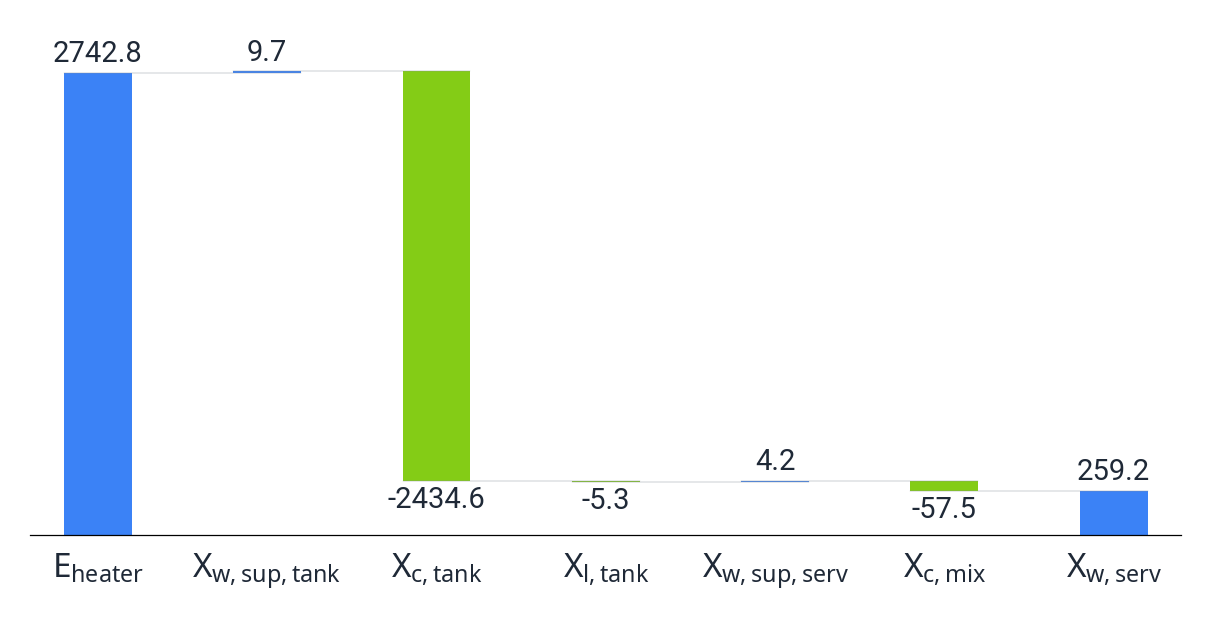

In [58]:
EB = ElectricBoiler()
EB.system_update()

# sub system names
sub_system = list(EB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(EB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in EB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in EB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(10), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'EB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

## GB

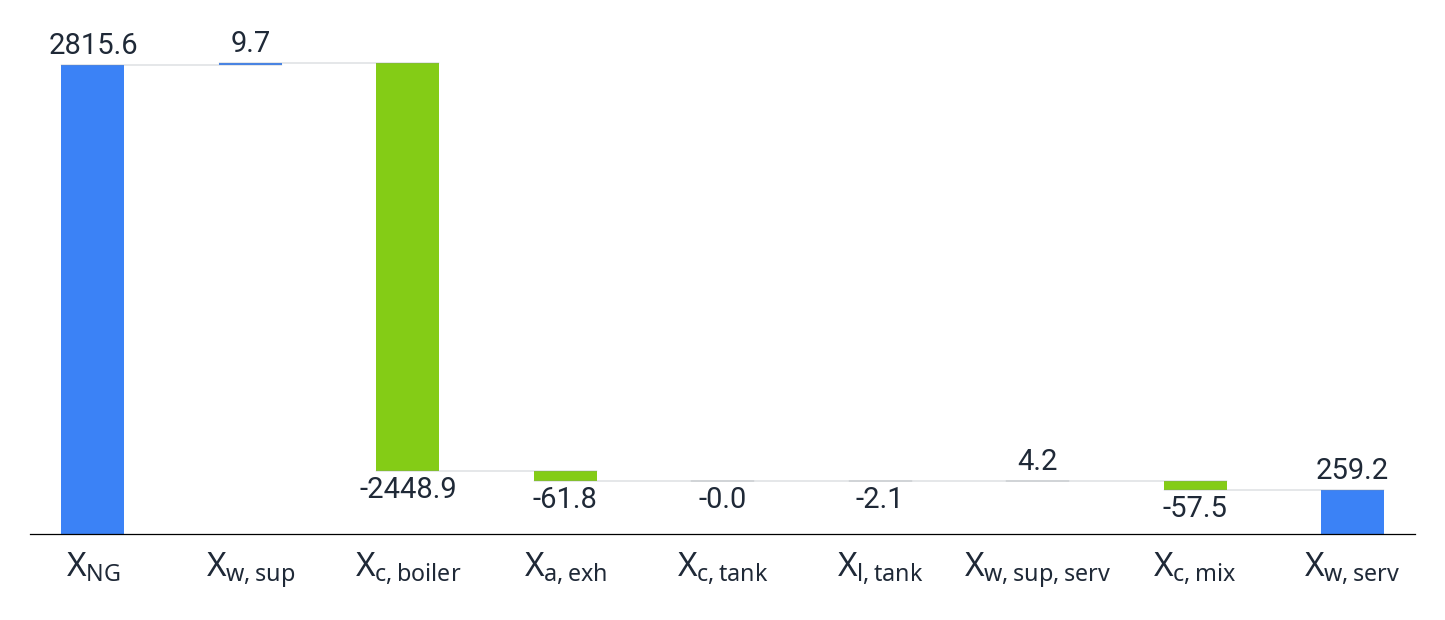

In [56]:
GB = GasBoiler()
GB.system_update()

# sub system names
sub_system = list(GB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(GB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in GB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in GB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        del new_values[matching_indices[0]]
        del new_labels[matching_indices[0]]
        del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(12), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 3000
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'GB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

## HPB

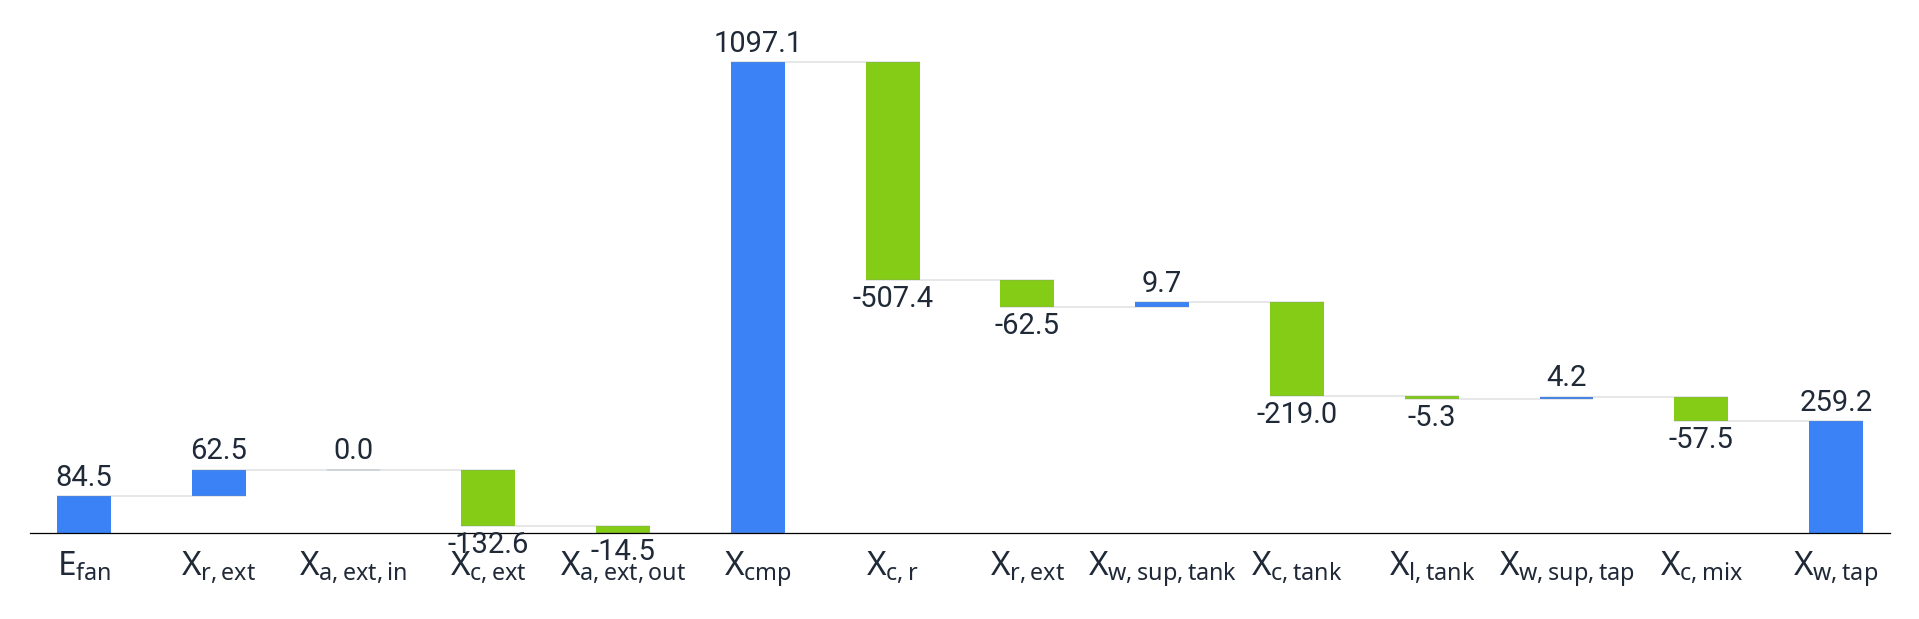

In [57]:
HPB = HeatPumpBoiler()
HPB.system_update()

# sub system names
sub_system = list(HPB.exergy_balance)

## Exergy values ========================================
values, labels, flows = [], [], [] 

for sub in sub_system:
    for flow in ['in', 'consumed', 'out']:
        flows.extend([flow for _ in range(len(HPB.exergy_balance[sub][flow]))])
        values.extend([dictionary['value'] if flow == "in" else -dictionary['value'] for dictionary in HPB.exergy_balance[sub][flow]])
        labels.extend([dictionary['symbol'] for dictionary in HPB.exergy_balance[sub][flow]])
values[-1] = abs(values[-1])

# 중복제거    
new_values, new_labels, new_flows = [], [], []
for idx, (target, label, flow) in enumerate(zip(values, labels, flows)):
    if any(abs(val) == abs(target) for val in new_values):  # 절댓값만 비교
        matching_indices = [i for i, val in enumerate(new_values) if abs(val) == abs(target)]
        if label =="$X_{r,ext}$": # 예외처리
            new_values.append(target)
            new_labels.append(label)
            new_flows.append(flow)
        else:
            del new_values[matching_indices[0]]
            del new_labels[matching_indices[0]]
            del new_flows[matching_indices[0]]
    else:
        new_values.append(target)
        new_labels.append(label)
        new_flows.append(flow)
        

cum_values = np.cumsum(new_values)

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(16), dm.cm2in(5)))

# Common settings
bar_width = 0.4
y_max = 1100
x_padding = 0.4
line_thickness = 0.1
text_padding = y_max * 0.01

# Function to draw connecting lines
def draw_waterfall_lines(ax, x, cum_values, line_thickness):
    for i in range(1, len(x)):
        start = cum_values[i-1]
        ax.plot([x[i-1]-bar_width/2, x[i]+bar_width/2], [start, start], color='dm.gray6', linestyle='-', linewidth=line_thickness)

#  plot
dN = len(new_values)
x = np.arange(dN)
colors = ["tw.blue:500" if val > 0 else "tw.lime:500" for val in new_values]

# Plot bars for 
for i in range(len(x)):
    if i == 0 or i == len(x) - 1: # 첫번째와 마지막 bar는 cumvalue를 bottom으로 설정하지 않음 -> 기본 바 형태로 그림
        ax.bar(x[i], new_values[i], bar_width, color=colors[i])
    else:
        ax.bar(x[i], new_values[i], bar_width, bottom=cum_values[i-1], color=colors[i]) # cumvalue를 bottom으로 설정하여 waterfall 형태로 그림

# Draw connecting lines for 
draw_waterfall_lines(ax, x, cum_values, line_thickness)

# Axis settings
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_yticks([])
ax.set_ylim(0, y_max)

# Set x-axis labels and limits
ax.set_xticks(x)
ax.set_xticklabels(new_labels, ha='center', fontsize=dm.fs(0.5), color = 'tw.gray:800')
ax.set_xlim(-x_padding, dN - 1 + x_padding)

# Spines settings
for k in ['top', 'right', 'left']:  # Only keep bottom spine
    ax.spines[k].set_visible(False)


# Add bar values as text
for i, value in enumerate(new_values):
    flow = new_flows[i]
    if i == 0 or i == dN - 1:
        height = new_values[i]
        va = 'bottom'
        y_pos = height + text_padding
    else:
        height = cum_values[i]
        va = 'bottom' if flow == 'in' else 'top'
        y_pos = height + text_padding if flow == 'in' else height - text_padding
    
    ax.text(i, y_pos, f'{value:.1f}', ha='center', va=va, fontsize=dm.fs(-0.5), weight=400, color = 'tw.gray:800')

dm.simple_layout(fig, margins=(0.05, 0.05, 0.05, 0.05), bbox=(0, 1, 0, 1), verbose=False)
fig_name = 'HPB_waterfall'
fig.savefig(f'../figure/{fig_name}.png', dpi=600)

In [42]:
new_flows

['in',
 'in',
 'in',
 'consumed',
 'out',
 'in',
 'consumed',
 'out',
 'in',
 'consumed',
 'out',
 'in',
 'consumed',
 'out']

In [36]:
values

[84.53877669764837,
 62.538696508684616,
 0.0,
 -132.61212574718797,
 -14.465347459144814,
 1097.1371990840223,
 -507.36267571993756,
 -527.2358268554003,
 -62.538696508684616,
 527.2358268554003,
 9.69685487714189,
 -219.02305069134053,
 -312.56161671217706,
 -5.348014329024446,
 312.56161671217706,
 4.155794947346525,
 -57.486734803461005,
 259.2306768560633]

In [37]:
new_values

[84.53877669764837,
 62.538696508684616,
 0.0,
 -132.61212574718797,
 -14.465347459144814,
 1097.1371990840223,
 -507.36267571993756,
 9.69685487714189,
 -219.02305069134053,
 -5.348014329024446,
 4.155794947346525,
 -57.486734803461005,
 259.2306768560633]

In [12]:
cum_values

array([  84.5387767 ,   84.5387767 ,  -48.07334905,  -62.53869651,
       1034.59850258,  527.23582686,  536.93268173,  317.90963104,
        312.56161671,  316.71741166,  259.23067686,  518.46135371])

In [38]:
print_balance(HPB.exergy_balance,'exergy')



EXTERNAL UNIT EXERGY BALANCE:=====================

IN ENTRIES:
$E_{fan}$: 84.54 [W]
$X_{r,ext}$: 62.54 [W]
$X_{a,ext,in}$: 0.0 [W]

CONSUMED ENTRIES:
$X_{c,ext}$: 132.61 [W]

OUT ENTRIES:
$X_{a,ext,out}$: 14.47 [W]


REFRIGERANT LOOP EXERGY BALANCE:==================

IN ENTRIES:
$X_{cmp}$: 1097.14 [W]

CONSUMED ENTRIES:
$X_{c,r}$: 507.36 [W]

OUT ENTRIES:
$X_{r,tank}$: 527.24 [W]
$X_{r,ext}$: 62.54 [W]


HOT WATER TANK EXERGY BALANCE:====================

IN ENTRIES:
$X_{r,tank}$: 527.24 [W]
$X_{w,sup,tank}$: 9.7 [W]

CONSUMED ENTRIES:
$X_{c,tank}$: 219.02 [W]

OUT ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{l,tank}$: 5.35 [W]


MIXING VALVE EXERGY BALANCE:======================

IN ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{w,sup,tap}$: 4.16 [W]

CONSUMED ENTRIES:
$X_{c,mix}$: 57.49 [W]

OUT ENTRIES:
$X_{w,tap}$: 259.23 [W]


In [ ]:
values

[84.53877669764837,
 62.538696508684616,
 0.0,
 132.61212574718797,
 14.465347459144814,
 1097.1371990840223,
 507.36267571993756,
 527.2358268554003,
 219.02305069134053,
 5.348014329024446,
 57.486734803461005,
 259.2306768560633]

In [ ]:
keys

['in',
 'consumed',
 'out',
 'in',
 'consumed',
 'out',
 'consumed',
 'out',
 'consumed',
 'out']

In [ ]:
print_balance(HPB.exergy_balance,'exergy')



EXTERNAL UNIT EXERGY BALANCE:=====================

IN ENTRIES:
$E_{fan}$: 84.54 [W]
$X_{r,ext}$: 62.54 [W]
$X_{a,ext,in}$: 0.0 [W]

CONSUMED ENTRIES:
$X_{c,ext}$: 132.61 [W]

OUT ENTRIES:
$X_{a,ext,out}$: 14.47 [W]


HOT WATER TANK EXERGY BALANCE:====================

IN ENTRIES:
$X_{r,tank}$: 527.24 [W]
$X_{w,sup,tank}$: 9.7 [W]

CONSUMED ENTRIES:
$X_{c,tank}$: 219.02 [W]

OUT ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{l,tank}$: 5.35 [W]


REFRIGERANT LOOP EXERGY BALANCE:==================

IN ENTRIES:
$X_{cmp}$: 1097.14 [W]

CONSUMED ENTRIES:
$X_{c,r}$: 507.36 [W]

OUT ENTRIES:
$X_{r,tank}$: 527.24 [W]
$X_{r,ext}$: 62.54 [W]


MIXING VALVE EXERGY BALANCE:======================

IN ENTRIES:
$X_{w,tank}$: 312.56 [W]
$X_{w,sup,tap}$: 4.16 [W]

CONSUMED ENTRIES:
$X_{c,mix}$: 57.49 [W]

OUT ENTRIES:
$X_{w,tap}$: 259.23 [W]


In [ ]:
print_balance(GB.exergy_balance,'exergy')

NameError: name 'GB' is not defined